In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
import yfinance as yf
import itertools
import math
import random


import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

from co import *
import ndtest

In [33]:
#Asset list from DBSCAN clusters - utilities
lst=('LNT','AEE','AEP','ATO','CNP','CMS','ED','D','DTE','DUK','EIX','ETR','EVRG','ES','EXC','FE')

#dates for model calibration
start_data='2021-09-01'
end_data='2022-09-01'

start_trade='2022-09-02'
end_trade='2022-12-02'

index_comp='SPY'
util_index_comp='VPU'

In [3]:
pair_order_list = itertools.combinations(lst,2)
pairs=list(pair_order_list)

In [ ]:
ret_df= pd.DataFrame()
for j in range(0,len(lst)):
    X = yf.download(lst[j], start = start_data, end=end_data)
    X.reset_index(inplace=True)
    X.tail()
    X['Log_Returns'] = np.log(X['Adj Close']) - np.log(X['Adj Close'].shift(1))
    x = X['Log_Returns'].drop(labels=0, axis=0)
    date=X['Date'].drop(labels=0,axis=0)
    date=date.to_frame()

    x_df=x.to_frame().dropna()

    b=x_df.rename(columns={'Log_Returns': lst[j]})
    b=b[lst[j]].values
    ret_df[lst[j]]=b

In [ ]:
co_pairs=[]
np.random.seed(107)
for i in range(0,len(pairs)):
    score, pvalue, _ = coint(np.cumsum(ret_df[pairs[i][0]]),np.cumsum(ret_df[pairs[i][1]]))

    confidence_level = 0.05

    if pvalue < confidence_level:
        co_pairs.append(pairs[i])
        print (pairs[i]," are cointegrated")
        print (pvalue)
    else:
        print (pairs[i]," are not cointegrated")
        print (pvalue)


In [27]:
print('Cointegrated pairs in the utilities cluster')
co_pairs

Cointegrated pairs in the utilities cluster


[('LNT', 'CNP'),
 ('LNT', 'ED'),
 ('LNT', 'D'),
 ('LNT', 'EIX'),
 ('LNT', 'ETR'),
 ('AEE', 'AEP'),
 ('AEE', 'CNP'),
 ('AEE', 'CMS'),
 ('AEE', 'DUK'),
 ('AEE', 'ETR'),
 ('AEP', 'CNP'),
 ('CNP', 'CMS'),
 ('CNP', 'ED'),
 ('CNP', 'DUK'),
 ('CNP', 'ETR'),
 ('CNP', 'EVRG'),
 ('CMS', 'ED'),
 ('CMS', 'D'),
 ('CMS', 'DTE'),
 ('CMS', 'DUK'),
 ('CMS', 'ETR'),
 ('CMS', 'EXC'),
 ('D', 'DTE'),
 ('D', 'EXC'),
 ('DTE', 'DUK'),
 ('DUK', 'ETR'),
 ('DUK', 'EXC'),
 ('EIX', 'EVRG'),
 ('EIX', 'ES')]

In [7]:
def get_hurst_exponent(time_series, max_lag=20):
        lags = range(2, max_lag)

        # variances of the lagged differences
        tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

        # calculate the slope of the log plot -> the Hurst Exponent
        reg = np.polyfit(np.log(lags), np.log(tau), 1)

        return reg[0]

In [8]:
pairs_df=pd.DataFrame(columns=['spread'])
hurst_list=[]
for i in range(0,len(co_pairs)):
    #calculate spread of adjusted close price between asset pair
    pairs_df['spread'] = np.abs(ret_df[co_pairs[i][0]] - ret_df[co_pairs[i][1]])

    hurst_exp = get_hurst_exponent(pairs_df['spread'].values)
    hurst_list.append(hurst_exp)

list_zip = zip(co_pairs,hurst_list)
zipped_list = list(list_zip)
zipped_list.sort(key=lambda a: a[1])

selected_stocks = []
selected_pairs = []
opt_asset1=[]
opt_asset2=[]
for i in range(0,len(co_pairs)):
    s1=co_pairs[i][0]
    s2=co_pairs[i][1]

    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        selected_stocks.append(s1)
        selected_stocks.append(s2)
        pair=s1+' and '+s2
        selected_pairs.append(pair)

    if len(selected_pairs) == math.comb(len(lst),2):
        break

opt_asset1=selected_stocks[0:len(selected_stocks)-1:2]
opt_asset2=selected_stocks[1:len(selected_stocks):2]

In [29]:
print('Selected pairs given cointegrated and minimum Hurst Exponent')
selected_pairs

Selected pairs given cointegrated and minimum Hurst Exponent


['LNT and CNP',
 'AEE and AEP',
 'CMS and ED',
 'D and DTE',
 'DUK and ETR',
 'EIX and EVRG']

In [30]:
opt_asset_list=opt_asset1+opt_asset2

In [ ]:
opt_ret_df= pd.DataFrame()
for j in range(0,len(opt_asset_list)):
    X = yf.download(opt_asset_list[j], start = start_trade, end=end_trade)
    X.reset_index(inplace=True)
    X.tail()
    X['Log_Returns'] = np.log(X['Adj Close']) - np.log(X['Adj Close'].shift(1))
    x = X['Log_Returns'].drop(labels=0, axis=0)
    date=X['Date'].drop(labels=0,axis=0)
    date=date.to_frame()
    
    x_df=x.to_frame().dropna()

    b=x_df.rename(columns={'Log_Returns': opt_asset_list[j]})
    b=b[opt_asset_list[j]].values
    opt_ret_df[opt_asset_list[j]]=b
    
x=opt_ret_df.join(date)
opt_ret_df=x.set_index('Date')

In [17]:
returns_trade_period=opt_ret_df

In [ ]:
df=pd.DataFrame()
best_cop_lst=[]
for i in range(0,len(opt_asset1)):
    #assets (yfinance ticker)
    x=ret_df[opt_asset1[i]]
    y=ret_df[opt_asset2[i]]
    pairs=selected_pairs[i] #insert name of asset 1 and asset 2

    #fit distribution to element in pair + probability integral transform to get marginal uniform

    param1 = stats.t.fit(x)
    dist1=stats.t(*param1)
    u=dist1.cdf(x)
    param2=stats.t.fit(y)
    dist2=stats.t(*param2)
    v=dist2.cdf(y)




    #fit bivariate copula family to data 
    #calculate Akaike information criterion, Bayesion information criterion and KS value to help determine good fit

    pair=[pairs]
    copulas_df = pd.DataFrame(index=pair, columns=['copula', 'parameter', 'aic', 'bic', 'KS_pvalue'])


    best_aic = np.inf
    best_copula= None


    copulas=[GaussianCopula(),GumbelCopula(), ClaytonCopula(),FrankCopula()]
    for copula in copulas:
        copula.fit(u,v)

        L = copula.log_likelihood(u,v)
        aic = 2 * copula.num_params - 2 * L
        if aic < best_aic:
            best_aic = aic
            best_bic = copula.num_params * np.log(len(u)) - 2 * L
            best_copula = copula

            # calculate KS-pvalue
            smp = copula.sample(size=len(u)) # generate sample from fit copula
            s_u = smp[:,0]
            s_v = smp[:,1]
            ks_pval = ndtest.ks2d2s(u,v,s_u,s_v)

            if isinstance(copula, ArchimedeanCopula):
                best_param = copula.alpha
            else:
                best_param = copula.rho

    best_cop_lst.append(best_copula)
    copulas_df.loc[pair] = [best_copula.name, best_param, best_aic, best_bic, ks_pval]
    df=df.append(copulas_df)

#dataframe of the returns for the specific trading period for each pair
algo_returns = {}
cl = 0.85

for q in range(0,len(selected_pairs)):
    # calculate conditional probabilities
    prob1=[]
    prob2=[]

    for u,v in zip(dist1.cdf(opt_ret_df[opt_asset1[q]]), dist2.cdf(opt_ret_df[opt_asset2[q]])):
        prob1.append(best_cop_lst[q].cdf_u_given_v(u,v))
        prob2.append(best_cop_lst[q].cdf_v_given_u(u,v))


    probs_trade= pd.DataFrame(np.vstack([prob1,prob2]).T,index=opt_ret_df.index, columns=[opt_asset1[q],opt_asset2[q]])



    #calculate positions
    positions=pd.DataFrame(index=probs_trade.index, columns = probs_trade.columns)
    long = False
    short = False


    for t in positions.index:    
        # if long position is open
        if long:
            if (probs_trade.loc[t][opt_asset1[q]] > 0.5) or (probs_trade.loc[t][opt_asset2[q]] < 0.5):
                positions.loc[t] = [0,0]
                long = False
            else:
                positions.loc[t] = [1,-1]

        # if short position is open
        elif short:
            if (probs_trade.loc[t][opt_asset1[q]] < 0.5) or (probs_trade.loc[t][opt_asset2[q]] > 0.5):
                positions.loc[t] = [0,0]
                short = False
            else:
                positions.loc[t] = [-1,1]

        # if no positions are open
        else:
            if (probs_trade.loc[t][opt_asset1[q]] < (1-cl)) and (probs_trade.loc[t][opt_asset2[q]] > cl):
                # open long position
                positions.loc[t] = [1,-1]
                long = True
            elif (probs_trade.loc[t][opt_asset1[q]] > cl) and (probs_trade.loc[t][opt_asset2[q]] < (1-cl)):
                # open short positions
                positions.loc[t] = [-1,1]
                short = True
            else:
                positions.loc[t] = [0,0]


    # calculate returns
    algo_ret = (returns_trade_period * positions.shift()).sum(axis=1)
    algo_returns[selected_pairs[q]] = algo_ret

rets = pd.DataFrame.from_dict(algo_returns)
rets = np.exp(rets) - 1 # convert log-returns to simple returns
total_ret = rets.sum(axis=1) / len(rets.columns) * 2 # double capital (from short positions)





In [21]:
# calculate returns
algo_ret = (returns_trade_period * positions.shift()).sum(axis=1)
algo_returns[pairs] = algo_ret

print('Algorithm returns for trading period:')
algo_ret

Algorithm returns for trading period:


Date
NaT           0.000000
2022-09-06    0.000000
2022-09-07    0.000000
2022-09-08    0.000000
2022-09-09    0.000000
                ...   
2022-11-23    0.003775
2022-11-25    0.000000
2022-11-28    0.000000
2022-11-29    0.000000
2022-11-30    0.000000
Length: 62, dtype: float64

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


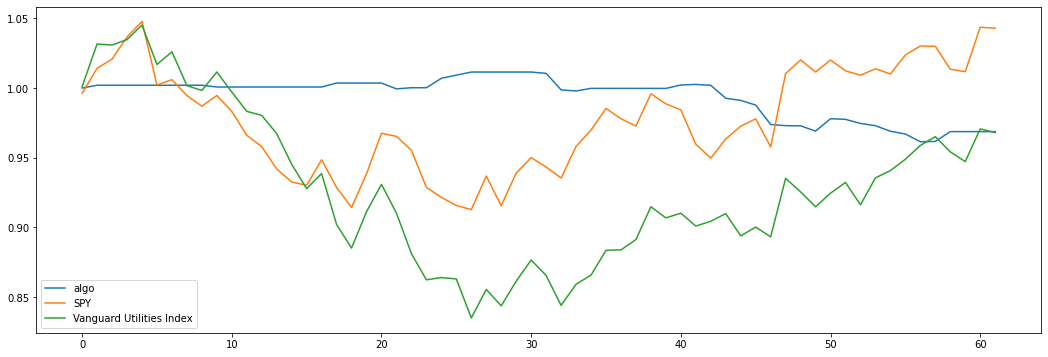

In [35]:
#Plot of algorithm returns vs. index return
#x-axis is # days from start of trading period
returns = pd.DataFrame.from_dict(algo_returns)
returns = np.exp(returns) - 1 # convert log-returns to simple returns
total_ret = returns.sum(axis=1) / len(returns.columns) * 2 # double capital (from short positions)

index_price = yf.download(index_comp, start=start_trade, end=end_trade)
index_price = index_price['Adj Close']
index_ret =index_price.pct_change().dropna()

util_index_price = yf.download(util_index_comp, start=start_trade, end=end_trade)
util_index_price = util_index_price['Adj Close']
util_index_ret =util_index_price.pct_change().dropna()

plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(total_ret + 1), label='algo')
plt.plot(np.nancumprod(index_ret + 1), label=index_comp)
plt.plot(np.nancumprod(util_index_ret + 1), label='Vanguard Utilities Index')
plt.legend()


In [25]:
def calculate_metrics(cumret):
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [26]:
#performance metrics
metrics = pd.DataFrame(index=['Algo', index_comp], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown', 'Max Length Drawdown'])
metrics.loc['Algo'] = calculate_metrics(np.nancumprod(total_ret + 1))
metrics.loc[index_comp] = calculate_metrics(np.nancumprod(index_ret + 1))

metrics

,Total return,APR,Sharpe,Max Drawdown,Max Length Drawdown
Algo,-0.031264,-0.121115,-2.35134,-0.049429,31.0
SPY,0.046815,0.204375,0.835238,-0.12883,57.0


## Algo performed equivalently to benchmark (utility index) and poorly in comparison to broader S&P